In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import time
%matplotlib inline

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

#from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, models

# if torch.cuda.is_available():
#     print('CUDA is available. Working on GPU')
#     DEVICE = torch.device('cuda')
# else:
#     print('CUDA is not available. Working on CPU')
#     DEVICE = torch.device('cpu')

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

/Users/caoyuxin/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available


In [2]:
tf.debugging.set_log_device_placement(False)

In [3]:
## Load the dateset
TRAIN_DIR = './FER2013/train/'
TEST_DIR = './FER2013/test/'

In [4]:
EMOTIONS = [
    "angry",
    "disgust",
    "fear",
    "happy",
    "neutral",
    "sad",
    "surprise",
]

In [5]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.3,
)

validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all train images
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

# Preprocess all validation images
validation_generator = validation_data_gen.flow_from_directory(
        TEST_DIR,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


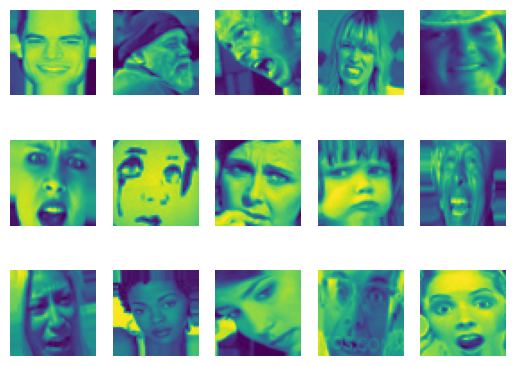

In [6]:
images, _ = next(train_generator)

fig = plt.figure()

# setting values to rows and column vriables
rows = 3
columns = 5

for i in range(0, 15):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(images[i])
    plt.axis('off')

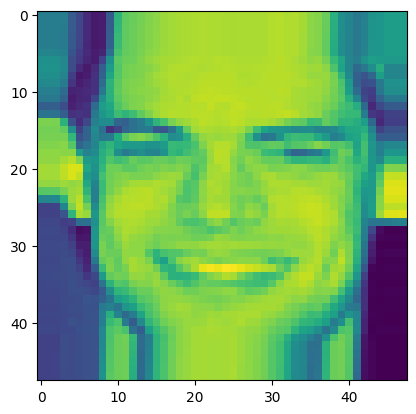

In [7]:
plt.imshow(images[0]) # display first image from batch

In [8]:
# print(next(train_generator)[0].shape)
# print(next(train_generator)[1].shape)
# images, labels = next(train_generator)
# images2, labels2 = next(train_generator)

In [9]:
train_X = np.empty([9600, 48, 48, 1])
train_Y = np.empty([9600, 7])
start = 0
end = 0
for i in range(0, 150):
    image, label = train_generator.next()
    end = end + image.shape[0]
    train_X[start:end, :, :, :] = image
    train_Y[start:end, :] = label
    start = start + image.shape[0]

In [10]:
val_X = np.empty([2560, 48, 48, 1])
val_Y = np.empty([2560, 7])
start = 0
end = 0
for i in range(0, 40):
    image, label = validation_generator.next()
    end = end + image.shape[0]
    val_X[start:end, :, :, :] = image
    val_Y[start:end, :] = label
    start = start + image.shape[0]

In [11]:
# train_X = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
# train_Y = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
# val_X = np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
# val_Y = np.concatenate([validation_generator.next()[1] for i in range(validation_generator.__len__())])

### Bayesian Neural Network 

In [12]:
def bayesian_neural_network(input_shape):
    
    """
    We use tf.keras.Model to as the base model for our Bayesian Neural Network
    We select our input node as the net input, and the last node as our output (predict node)
    We will optimize the with a loss function @tf.function for loss
    Parameter: input shape - a tuple specifying the shape of input layer
    """
    
    input_model = tf.keras.layers.Input(shape=input_shape)
    
    #block-1
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_1(input_model)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    #block-2
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    
    #block-3
    dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
    x = dense_1(x)
    
    #block-4
    dense_2 = tfp.python.layers.DenseFlipout(7, activation=None)
    output_model = dense_2(x)  # logits
    model = tf.keras.Model(input_model, output_model)
    return model

In [13]:
"""
Loss function: A sum of KL Divergence and Softmax cross entropy
We return the mean of two losses; that is, we put equal weights of two losses
"""

@tf.function
def elbo_loss(labels, logits):
    softmax_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    kl_loss = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(softmax_en, kl_loss))
    return loss

In [14]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = bnn_model(train_X)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bnn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bnn_model.trainable_variables))
    return loss

def cal_accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))

In [15]:
#bnn_model = bayesian_neural_network(X_train.shape[1:])
bnn_model = bayesian_neural_network(train_X.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)

/Users/caoyuxin/opt/miniconda3/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
2022-12-07 01:54:42.189337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 01:54:42.189989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/caoyuxin/opt/miniconda3/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the 

Metal device set to: Apple M1


/Users/caoyuxin/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
times = []
accs = []
val_accs = []
losses = []
val_losses = []
preds = []
val_preds = []

for i in range(60):
    tic = time.time()
    loss = train_step(train_X, train_Y)
    pred = bnn_model(train_X)
    preds.append(pred)
    acc = cal_accuracy(pred, train_Y)
    accs.append(acc)
    losses.append(loss)
    
    val_pred = bnn_model(val_X)
    val_preds.append(val_pred)
    val_loss = elbo_loss(val_pred, val_Y)
    val_acc = cal_accuracy(val_pred, val_Y)
    
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    tac = time.time()
    train_time = tac-tic
    times.append(train_time)
    
    print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, val_loss = {:7.3f}, val_acc={:7.3f} time: {:7.3f}".format(i, loss, acc, val_loss, val_acc, train_time))

2022-12-07 01:54:45.165721: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 01:54:45.274844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-07 01:54:55.383538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch: 0: loss =  13.283 , accuracy =   0.169, val_loss = 407.982, val_acc=  0.181 time:  12.822
Epoch: 1: loss =  46.572 , accuracy =   0.150, val_loss = 256.953, val_acc=  0.152 time:   7.336
Epoch: 2: loss =  23.176 , accuracy =   0.168, val_loss = 141.794, val_acc=  0.183 time:   7.803
Epoch: 3: loss =   7.964 , accuracy =   0.137, val_loss =  84.237, val_acc=  0.142 time:   7.129
Epoch: 4: loss =   3.762 , accuracy =   0.133, val_loss =  50.295, val_acc=  0.125 time:   6.379
Epoch: 5: loss =   2.881 , accuracy =   0.124, val_loss =  50.780, val_acc=  0.120 time:   6.732
Epoch: 6: loss =   2.704 , accuracy =   0.124, val_loss =  60.971, val_acc=  0.123 time:   8.457
Epoch: 7: loss =   2.485 , accuracy =   0.142, val_loss =  74.589, val_acc=  0.143 time:  10.590
Epoch: 8: loss =   2.276 , accuracy =   0.178, val_loss =  89.708, val_acc=  0.173 time:   8.094
Epoch: 9: loss =   2.087 , accuracy =   0.208, val_loss = 103.701, val_acc=  0.214 time:  10.197
Epoch: 10: loss =   1.970 , ac

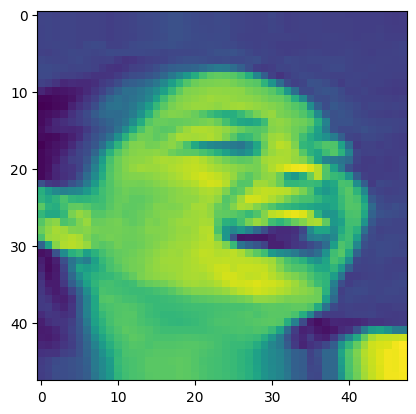

In [17]:
plt.imshow(train_X[0])

<BarContainer object of 7 artists>

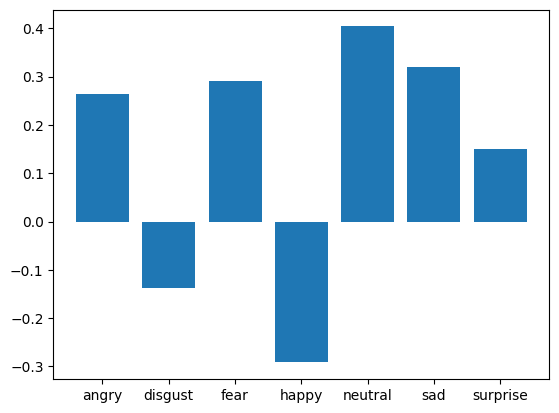

In [18]:
values = preds[0][0] / sum(preds[0][0])
plt.bar(EMOTIONS, values)

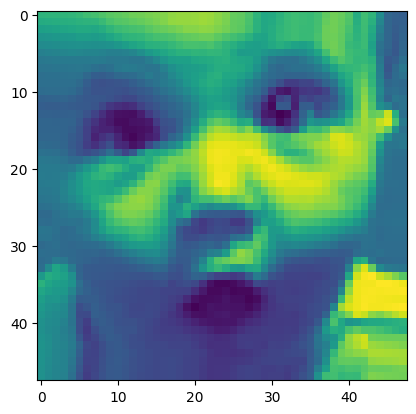

In [19]:
plt.imshow(train_X[1])

<BarContainer object of 7 artists>

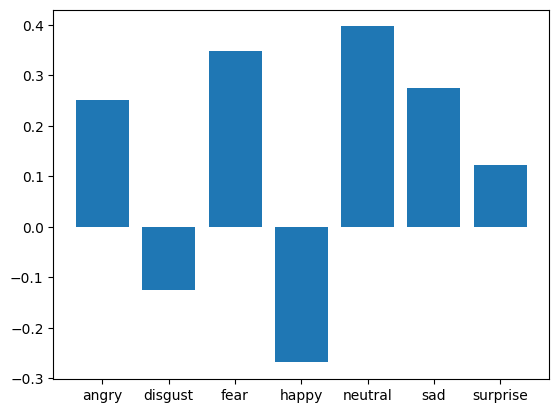

In [20]:
values = preds[0][1] / sum(preds[0][1])
plt.bar(EMOTIONS, values)

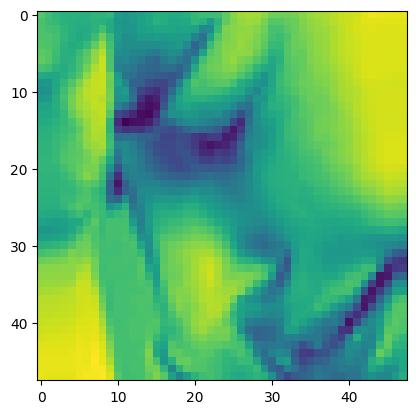

In [21]:
plt.imshow(train_X[2])

<BarContainer object of 7 artists>

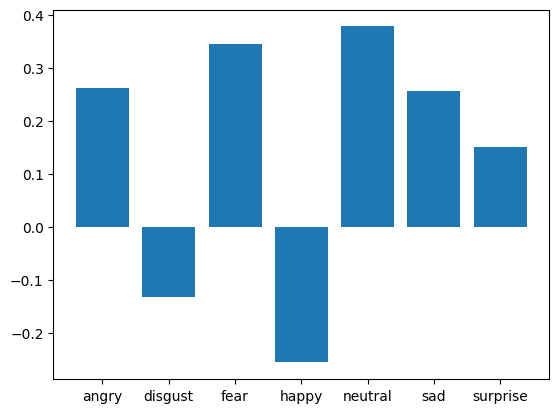

In [22]:
values = preds[0][2] / sum(preds[0][2])
plt.bar(EMOTIONS, values)

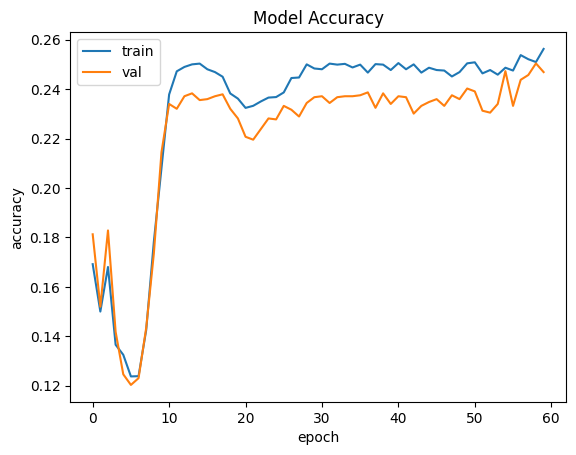

In [23]:
# plot accuracy
plt.plot(accs)
plt.plot(val_accs)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

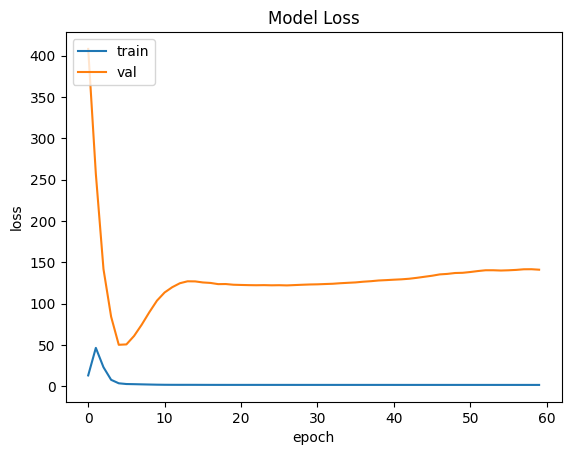

In [24]:
# plot loss
plt.plot(losses)
plt.plot(val_losses)
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()